In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from datetime import datetime
import joblib

# Load dataset
df = pd.read_csv("OnlineRetail.csv")


In [9]:
# Remove null values
df.dropna(inplace=True)

# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [11]:
print("Dataset Info After Cleaning:")
df.info()

Dataset Info After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


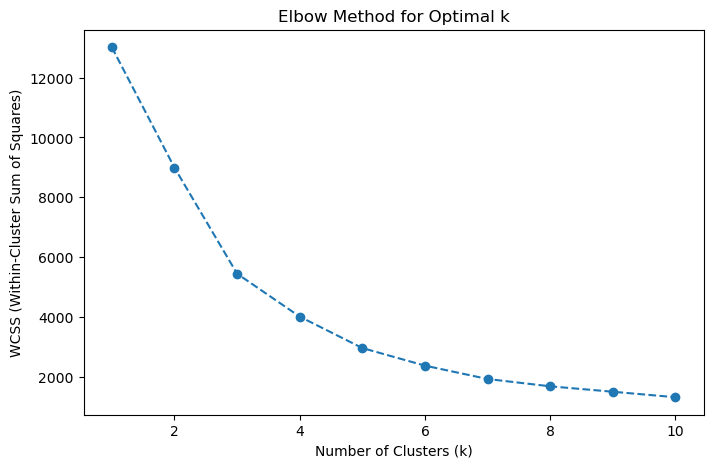

K-Means Silhouette Score: 0.6022759587511283
Trained K-Means model and scaler saved!


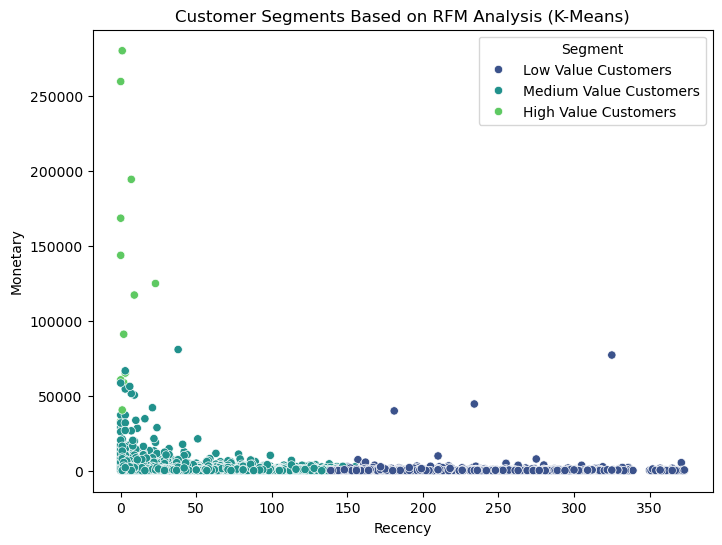

Customer Segmentation with Labels Saved!


In [29]:
# Convert InvoiceDate to datetime with specified format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%d-%m-%Y %H:%M")

# Remove cancelled transactions (where InvoiceNo starts with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Create TotalPrice feature
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Remove negative quantities and unit prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Extract date-based features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.weekday

# Compute Recency, Frequency, and Monetary (RFM) per CustomerID
latest_date = df['InvoiceDate'].max()
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Scale RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Determine optimal k using Elbow Method
wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Train K-Means with optimal clusters
best_k = 3  # Adjusted based on Elbow method
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10, max_iter=300)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)
kmeans_score = silhouette_score(rfm_scaled, kmeans.labels_)
print(f"K-Means Silhouette Score: {kmeans_score}")

# Assign meaningful labels based on RFM values
cluster_mapping = {
    0: "Low Value Customers",
    1: "Medium Value Customers",
    2: "High Value Customers"
}
rfm['Segment'] = rfm['KMeans_Cluster'].map(cluster_mapping)

# Save the trained K-Means model
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Trained K-Means model and scaler saved!")

# Visualize clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='viridis')
plt.title("Customer Segments Based on RFM Analysis (K-Means)")
plt.show()

# Save clustered dataset with labels
rfm.to_csv("customer_segments_labeled.csv", index=True)
print("Customer Segmentation with Labels Saved!")



In [27]:
# Analyze cluster characteristics
print(rfm.groupby("KMeans_Cluster").mean())


                   Recency    Frequency       Monetary
KMeans_Cluster                                        
0               246.308333    27.402778     635.651871
1                40.377196   101.734977    2022.479955
2                 3.692308  2535.923077  125981.340000


In [31]:
print(rfm['Segment'].value_counts())


Segment
Medium Value Customers    3245
Low Value Customers       1080
High Value Customers        13
Name: count, dtype: int64


In [33]:
print(rfm.groupby("Segment").mean())


                           Recency    Frequency       Monetary  KMeans_Cluster
Segment                                                                       
High Value Customers      3.692308  2535.923077  125981.340000             2.0
Low Value Customers     246.308333    27.402778     635.651871             0.0
Medium Value Customers   40.377196   101.734977    2022.479955             1.0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
 9   Year         392692 non-null  int32         
 10  Month        392692 non-null  int32         
 11  Day          392692 non-null  int32         
 12  Hour         392692 non-null  int32         
 13  Weekday      392692 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(5), int64(1), object(4)
memory usage: 37.5+ MB
